# Importowane biblioteki

torch - główna biblioteka projektu znanego jako PyTorch, obecnie jedna z najpopularniejszych bibliotek do Uczenia Głębokiego

torch.nn - moduł z biblioteki torch zawierający klasy (funkcje) odpowiadające za implementację wszystkich bloków funkcjonalnych sieci neuronowych takich jak warstwy, funkcje aktywacyjne czy funkcje kosztu.

torch.optim - moduł biblioteki torch zawierający implementację optymalizatorów takich jak SGD, Ada czy Adam.

torchvision - inna z bibliotek projektu PyTorch, zawierająca popularne datasety, modele czy transormacje z dziedziny wizji komputerowej.

torch.utils.data.Dataloader - klasa, która odpowiada za załadowanie zbioru danych w celu przeprowadzenia treningu modeli

matplotlib - biblioteka umożliwiająca wizualizację danych

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as tf
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Definiowanie własnego modelu

PyTorch umożliwia oczywiście definicję swoich własnych modeli. Zostały do tego przygotowane funkcje z wyżej wymienionych modułów.

W celu zdefiniowania własnego modelu sieci neuronowej należy się trzymać kilku reguł

* Klasa naszego modelu musi dzidziczyć po klasie abstrakcyjnej `nn.Module`
* W tym celu klasa musi implementować metody abstrakcyjne `__init__` oraz `forward`
* Na początku metody `__init__` wywołujemy konstruktor "rodzica".

Dla przykładu w poniższej komórce zdefiniujemy prostą sieć neuronową.



In [2]:
class ExampleModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.layer1 = nn.Linear(28*28, 64)
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 10)
    self.activation = nn.ReLU()
    self.Softmax = nn.Softmax(dim=0)

  def forward(self, x):
    out = x.view(-1, 28*28)
    out = self.activation(self.layer1(out))
    out = self.activation(self.layer2(out))
    out = self.Softmax(self.layer3(out))
    return out

Powyższy model jest typowym przykładem sieci typu Feed Forward, nazywanym również Multilayer Perceptron (MLP).

Zaimplementowana przez nas sieć składa się z 3 warst liniowych:
* warstwy wejściowej
* warstwy ukrytej
* warstwy wyjściowej

Pierwsze dwie warstwy aktywowane są za pomocą funkcji ReLu, natomiast warstwa wyjściowa korzysta z funkcji Softmax.
Zgodnie z zasadą sieci MLP, rozmiar danych wejściowych do warstwy **L** musi być równy rozmiarowi warstwy wyjściowej **L - 1** np.

```
    self.layer1 = nn.Linear(28*28, 64)
    self.layer2 = nn.Linear(64, 32)
```

### Slajd ze spotkanie "Wprowadzenie do uczenia głębokiego"
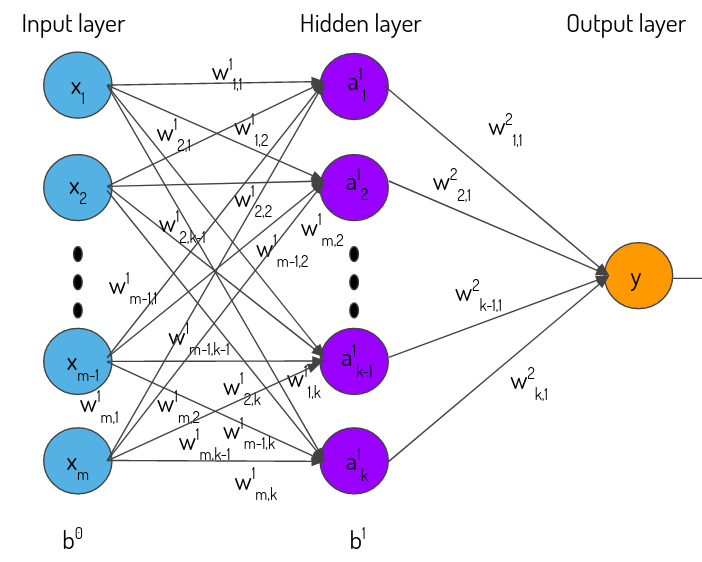

### Funkcja aktywacji ReLu

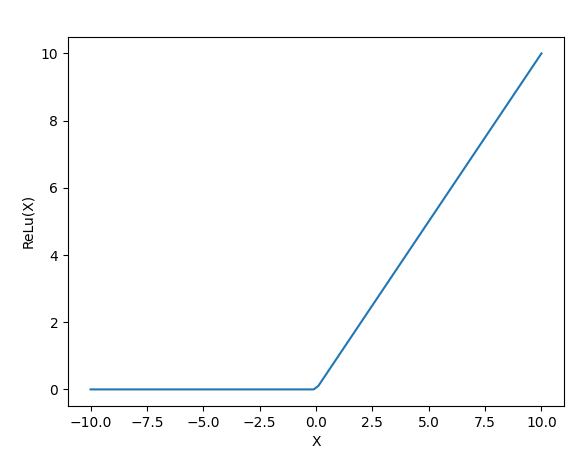

Funkcja ReLu obliczana jest zgodnie ze wzorem

$$
    ReLu(x) = max(x, 0)
$$

i jej celem jest zapewnienie, że pochodna liczona przez metodę Gradientu Prostego będzie przyjmowała 2 wartości: 0 i 1.
Pozwala to na zapobieżenie zjawisku zanikających gradientów.

### Funkcja Softmax

Celem funkcji **Softmax** jest zapewnienie, aby wartości podanego wektora sumowały się do jedności.

Wracając do kodu:

W konstruktorze klasy `__init__` definiowana jest architektura sieci:
```
    self.layer1 = nn.Linear(28*28, 64)
    self.layer2 = nn.Linear(64, 32)
    self.layer3 = nn.Linear(32, 10)
    self.activation = nn.ReLU()
    self.Softmax = nn.Softmax(dim=0)
```

natomiast w funkcji `forward()` implementowany jest przepływ danych przez sieć.

W poniższym kodzie możemy zauważyć inny sposób definiowania sieci neuronowej. W tym celu wykorzystana została klasa `Sequential()` która odpowiada za implementację tzw. mdoelu sekwencyjnego, czyli takiego, w którym przepływ danych może się odbywać jedynie według zdefiniowanej w konstruktorze sekwencji. 

In [3]:
class ExampleModel2(nn.Module):
  def __init__(self):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(28*28, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Linear(64, 10),
        nn.Softmax()
    )

  def forward(self, x):
    out = x.view(-1, 28*28)
    return self.net(out)


# Hiperparametry

Do szybszego uczenia się modelu stosujemy parametry takie jak "szybkość dostosywania wag".

Proces treningu modelu sieci neuronowej jest definiowany za pomocą tzw. hiperparametrów.

Do hiperparametrów zaliczamy takie zmienne jak:
- wielkość kroku uczenia się *(ang. learning rate)*
- wielkość batcha, czyli tzw. paczki danych*
- ilość epok treningu, czyli kolejnych iteracji po zbiorze treningowym
- jak mogą zmieniać się wagi, na przykład, że nie mogą przekraczać wyznaczonej wartości
- rozmiar wyjściowego obrazu

Zestaw hiperparametrów będzie się różnić w zależności od trenowanego modelu, ale najcześciej występującymu są właśnie wielkość kroku uczenia się, rozmiar batcha i liczba epok treningu.

<small>**paczka (batch) to zestaw danych wejściowych które zostaną wprowadzone na wejście do modelu/sieci neuronowej, rozmiar batcha oznacza ile danych wejściowych dostanie przetworzonych zanim model zaktualizuje wagi*</small>

In [4]:
learning_rate = 1e-2
batch_size = 128
num_epochs = 20

# Inicjalizacja modelu 

Zanim zaczniemy trening musimy określić na jakim urządzeniu będą realizowane obliczenia. Możemy wybrać jedną z dwóch opcji - trenować model za pomocą naszej jednostki GPU (ang. graphics processing unit) potocznie nazywaną kartą graficzną albo na wykonywać obliczenia za pomocą CPU (ang. central processing unit). Do obsługi karty graficznej potrzebny jest sterownik CUDA (ang. Compute Unified Device Architecture) jeśli korzysta z kart firmy NVIDIA lub ROCm (ang. Radeon Open Compute platforM) w przypadku sprzętu firmy AMD.
Obecnie najpopularniejszą platformą obliczeniową są karty graficzne firmy NVIDIA.

Pierwsza linijka kodu sprawdza czy oprogramowanie cuda jest dostępne i można go używać, a jeżeli nie, to wykorzystywany jest CPU.

W następnej linicje kodu tworzony jest obiekt naszej klasy modelu i lokowany jest on naszym urządzeniu.

W kolejnych dwóch linijkach ustalamy sposób liczenia funkcji straty oraz algorytm optymalizacji wag modelu.

(Kilka słów tłumaczących jakie funkcje strat służą do jakich modeli oraz czym mogą się różnić poszczególne optymalizatory)


Przykładowe funkcje strat i ich użycia:
- MSE (mean square error) - używane do regresji liniowej
$$
MSE = \frac{1}{n} ∑_{i=1}^{n}(y_i - ŷ_i)^2
$$

- L1 loss (mean absolute error) - używane do regresji liniowej

$$
MAE = \frac{1}{n} ∑_{i=1}^{n}|y_i - ŷ_i|
$$

- cross entropy loss - używane do klasyfikacji (dwie klasy lub wiele klas)

$$
BinaryCrossEntropyLoss = -\frac{1}{n}∑_{i=1}^{n}(log(ŷ_i) + (1 - y_i)log(1-ŷ_i))
$$

$$
CrossEntropyLoss = -\frac{1}{n}∑_{i=1}^{n}(y_i * log(ŷ_i))
$$

Optimizery:

- SGD (Stochastic gradient descent) - aktualizuje wagi sieci na podstawie wyliczonego gradientu i learning rate'u.

- Adam - aktualizuje wagi sieci na podstawie informacji o poprzednich gradientach, wyliczonego gradientu i learning rate'u.
https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = ExampleModel2().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Dane treningowe i testowe

Podczas procesu uczenia modelu wyróżniamy 3 typy danych biorących udział w tym procesie:
- dane treningowe - na nich uczony jest model
- dane walidacyjne - na nich walidowany jest co epokę model i testowane jest, czy model nie zaczyna być przeuczony
- dane testowe - finalnie wykorzystane do testu modelu, który miał najlepszy wynik na zbiorze walidacyjnym.

Sposób podziału zbioru danych na powyższe podzbiory zależy od zadania, samego zbioru i założenia, jakie przyjął autor.

Zanim zaczniemy trenować nasz model musimy przeprowadzić transformację danych. Transfromacja danych służy zmianie struktury danych do postaci wykorzystywanej przez modele w bibliotece torch.

W tym celu korzystamy z klasy Compose z biblioteki torchvision, definiując pakiet transformacji naszych danych. W poniższym kodzie jest to:
- przekształcenie formatu danych do klasy torch.Tensor() [https://pytorch.org/tutorials/beginner/examples_tensor/polynomial_tensor.html]
- stosujemy normalizacje, czyli przetwarzamy dane do wartości z przedziału [0, 1], aby zapewnić większą stabilność obliczeniową podczas treningu

W tym przykładzie wykorzystamy zbiór danych MNIST, dosßępny w module torch.datasets wczytując jego podzbiory treningowy i testowy.

W dalszej części kodu tworzy obiekty klasy DataLoader, służacej do załadowywania batchów danych do treningu modelu.

In [6]:
transforms = tf.Compose([
    tf.ToTensor(),
    tf.Normalize((0.5,), (0.5,))
])

train_dataset = datasets.MNIST(root="./dataset", train=True, transform=transforms,download=True)
test_dataset = datasets.MNIST(root="./dataset", train=False, transform=transforms,download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

100%|████████████████████████████| 9912422/9912422 [00:01<00:00, 7474760.86it/s]


Extracting ./dataset/MNIST/raw/train-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|███████████████████████████████| 28881/28881 [00:00<00:00, 20867475.25it/s]

Extracting ./dataset/MNIST/raw/train-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



100%|████████████████████████████| 1648877/1648877 [00:00<00:00, 9213768.37it/s]


Extracting ./dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to ./dataset/MNIST/raw



100%|██████████████████████████████████| 4542/4542 [00:00<00:00, 8539008.86it/s]

Extracting ./dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./dataset/MNIST/raw



(28, 28)


/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


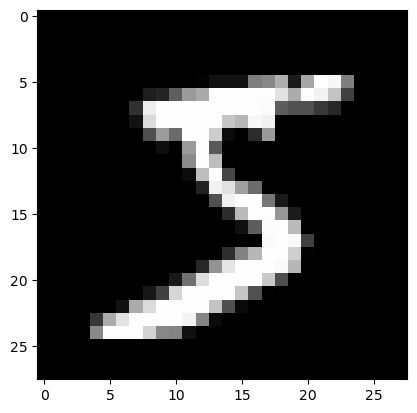

In [7]:
print(train_dataset.train_data[0].numpy().shape)
plt.imshow(train_dataset.train_data[0].numpy(), cmap='gray')
plt.show()

# Pętla treningowa

Definiujemy pętlę for iterującą po każdej epoce treningu, wewnątrz której iterujemy po paczkach (batches) danych treningowych i w każdej iteracji:

- ładujemy dane wejściowe i etykiety (labels) na urzadzenie obliczeniowe
- model generuje output z danych wejściowych
- obliczamy różnice między wynikami modelu a etykietami
- zerujemy gradient który był wcześniej obliczany
- obliczamy gradient z funkcji straty
- aktualizujemy wagi w naszym modelu

In [8]:
print(device)

cpu


In [9]:
step = 0
total_steps = len(train_loader) * num_epochs

for epoch in range(num_epochs):
  for batch_idx, (images, labels) in enumerate(train_loader):
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)

      loss = criterion(outputs, labels)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if batch_idx % 500 == 0:
        print(f'Epoch: {epoch}/{num_epochs} | Step: {step}/{total_steps} | Loss: {loss}')
      step += 1

/opt/homebrew/Caskroom/miniconda/base/lib/python3.10/site-packages/torch/nn/modules/container.py:139: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0/20 | Step: 0/9380 | Loss: 2.3039307594299316
Epoch: 1/20 | Step: 469/9380 | Loss: 2.292661190032959
Epoch: 2/20 | Step: 938/9380 | Loss: 2.2458322048187256
Epoch: 3/20 | Step: 1407/9380 | Loss: 2.142742872238159
Epoch: 4/20 | Step: 1876/9380 | Loss: 2.0330896377563477
Epoch: 5/20 | Step: 2345/9380 | Loss: 1.9220341444015503
Epoch: 6/20 | Step: 2814/9380 | Loss: 1.9266160726547241
Epoch: 7/20 | Step: 3283/9380 | Loss: 1.7986879348754883
Epoch: 8/20 | Step: 3752/9380 | Loss: 1.7855241298675537
Epoch: 9/20 | Step: 4221/9380 | Loss: 1.7555978298187256
Epoch: 10/20 | Step: 4690/9380 | Loss: 1.811223030090332
Epoch: 11/20 | Step: 5159/9380 | Loss: 1.7303141355514526
Epoch: 12/20 | Step: 5628/9380 | Loss: 1.681731939315796
Epoch: 13/20 | Step: 6097/9380 | Loss: 1.723688006401062
Epoch: 14/20 | Step: 6566/9380 | Loss: 1.7067844867706299
Epoch: 15/20 | Step: 7035/9380 | Loss: 1.730453610420227
Epoch: 16/20 | Step: 7504/9380 | Loss: 1.7854843139648438
Epoch: 17/20 | Step: 7973/9380 | Lo

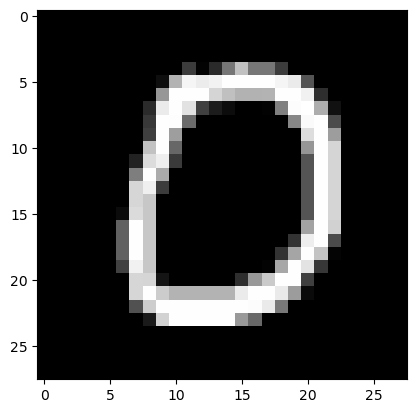

Szansa na:
0 - 0.9977
1 - 0.0000
2 - 0.0001
3 - 0.0001
4 - 0.0000
5 - 0.0000
6 - 0.0000
7 - 0.0000
8 - 0.0020
9 - 0.0000
Prawdziwa liczba
tensor(0)


In [12]:
i = 10 % batch_size # tutaj wybieramy obrazek
examples = enumerate(test_loader) # używamy danych testowych
batch_idx, (example_image, example_labels) = next(examples)
plt.imshow(example_image.numpy()[i][0], cmap='gray')
plt.show()
result = model(example_image[i][0])
print(f'Szansa na:')
print(f'0 - {result[0][0]:.4f}')
print(f'1 - {result[0][1]:.4f}')
print(f'2 - {result[0][2]:.4f}')
print(f'3 - {result[0][3]:.4f}')
print(f'4 - {result[0][4]:.4f}')
print(f'5 - {result[0][5]:.4f}')
print(f'6 - {result[0][6]:.4f}')
print(f'7 - {result[0][7]:.4f}')
print(f'8 - {result[0][8]:.4f}')
print(f'9 - {result[0][9]:.4f}')
print('Prawdziwa liczba')
print(example_labels[i])